In [ ]:
#| hide
#| default_exp word_embeddings

In [ ]:
#| hide
%matplotlib inline

# An introduction to word embeddings
(follows: https://github.com/nlptown/nlp-notebooks/blob/master/An%20Introduction%20to%20Word%20Embeddings.ipynb)

## Training word embeddings

We use Gensim. We use the abstracts of all arXiv papers in the category cs.CL (CL: Computation and Language) published before mid-April 2021 (c. 25_000 documents). We tokenize the abstracts with spaCy.

In [ ]:
#| export
import sys
import os
import csv
import spacy

class Corpus(object):
    def __init__(self, filename):
        self.filename = filename
        self.nlp = spacy.blank("en")

    def __iter__(self):
        with open(self.filename, "r") as i:
            reader = csv.reader(i, delimiter=',')
            for _, abstract in reader:
                tokens = [t.text.lower() for t in self.nlp(abstract)]
                yield tokens

documents = Corpus("/home/peter/Documents/data/nlp/arxiv.csv")

Using Gensim we can set a number of parameters for training:

- min_count: the minimum frequency of words in our corpus
- window: number of words to the left and right to make up the context that word2vec will take into account
- vector_size: the dimensionality of the word vectors; usually between 100 and 1_000
- sg: One can choose fro 2 algorithms to train word2vec: Skip-gram (sg) tries to predict the context on the basis of the target word; CBOW tries to find the target on the basis of the context. Default is sg=0, hence: default is CBOW.

In [ ]:
#| export
import gensim

model = gensim.models.Word2Vec(documents, min_count=100, window=5, vector_size=100)

## Using word embeddings

With the model trained, we can access the word embedding via the **wv attribute** on model using the token as a key. For example the embedding for "nlp" is:

In [ ]:
#| export
model.wv["nlp"]

array([ 1.8400488 , -1.8734728 ,  1.2907175 , -0.75806326,  0.74612266,
        0.25736544,  0.30584207, -0.8327874 , -0.4343027 ,  0.95746833,
        1.2405782 , -2.5892408 ,  1.1776707 ,  0.7893499 , -0.16112009,
        0.43330687, -0.21888173,  1.4320091 ,  0.59753084,  2.0778956 ,
        1.0784762 , -0.1302945 , -0.07693619,  0.84700763, -2.809797  ,
       -2.9693303 ,  1.3591033 ,  2.0079074 ,  1.9823503 , -0.5764397 ,
        0.38892773,  0.77810276,  1.7753881 ,  0.76062435,  0.03947029,
       -0.29899964, -0.89242697, -4.5439067 ,  0.5219558 ,  1.857145  ,
       -2.8032076 , -0.835726  ,  1.200288  ,  0.2013748 , -1.555861  ,
        1.1714945 ,  1.0639141 ,  2.7994676 , -0.53059286, -2.1437314 ,
        0.7464486 ,  1.0739055 , -0.07817048, -1.1349925 ,  0.94185805,
        0.18807782, -0.8907597 , -0.09755886,  4.0767865 ,  0.1289686 ,
       -0.23342434,  2.276507  , -1.8602846 ,  1.3030243 , -0.07700291,
       -0.86967236, -1.3861109 , -2.419579  ,  0.2309862 , -0.19

**Find the similarity between two words.** We use the cosine between two word embeddings, so we use a ranges between -1 and +1. The higher the cosine, the more similar two words are.

In [ ]:
#| export
print(model.wv.similarity("nmt", "smt"))
print(model.wv.similarity("nmt", "ner"))

0.65108514
0.3887788


**Find words that are most similar to target words** we line up words via the embeddings: semantically related, other types of pre-tained models, related general models, and generally related words:

In [ ]:
#| export
model.wv.similar_by_word("bert", topn=10)

[('roberta', 0.7613053917884827),
 ('transformer', 0.7606918811798096),
 ('transformers', 0.7130455374717712),
 ('elmo', 0.689378023147583),
 ('pretrained', 0.6837702989578247),
 ('mbert', 0.6633535027503967),
 ('xlm', 0.6349712610244751),
 ('gpt-2', 0.6339055299758911),
 ('lstm', 0.6321924328804016),
 ('xlnet', 0.6241547465324402)]

**Look for words that are similar to something, but dissimilar to something else** with this we can look for a kind of **analogies**:

In [ ]:
#| export
model.wv.most_similar(positive=["transformer", "lstm"], negative=["bert"], topn=1)

[('rnn', 0.8074556589126587)]

So a related transformer to lstm is rnn, just like bert is a particular type of transformer; really powerful.

We can also zoom in on **one of the meanings of ambiguous words**. In NLP **tree** has a very specific meaning, is nearest neighbours being: constituency, parse, dependency, and syntax:

In [ ]:
#| export
model.wv.most_similar(positive=["tree"], topn=10)

[('trees', 0.7845308184623718),
 ('recursive', 0.731972336769104),
 ('parse', 0.7278901934623718),
 ('constituency', 0.7257475256919861),
 ('dependency', 0.6613130569458008),
 ('syntax', 0.6136325001716614),
 ('parser', 0.6107826232910156),
 ('constituent', 0.6084973812103271),
 ('transition', 0.6058615446090698),
 ('grammar', 0.5820280313491821)]

If we add **syntax** as a negative input to the query, we see that the ordinary meaning of tree kicks in: Now forest is one of the nearest neighbours.

In [ ]:
#| export
model.wv.most_similar(positive=["tree"], negative=["syntax"], topn=10)

[('forest', 0.5145275592803955),
 ('logistic', 0.4439130425453186),
 ('bayes', 0.44311901926994324),
 ('crf', 0.438603013753891),
 ('normalized', 0.4247363209724426),
 ('applies', 0.42111313343048096),
 ('softmax', 0.41927337646484375),
 ('greedy', 0.416427880525589),
 ('nearest', 0.4015056788921356),
 ('maximum', 0.39835605025291443)]

**Throw a list of words at the model** and filter out the odd one (here svm is the only non-neural model):

In [ ]:
#| export
print(model.wv.doesnt_match("lst cnn gru transformer svm".split()))

svm


## Plotting embeddings

About visualizing embeddings. We need to reduce our 100-dimensions space to 2-dimensions. We can use t-SNE method: map similar data to nearby points and dissimilar data to faraway points in low dimensional space.

t-SNE is present in Scikit-learn. One has to specify two parameters: **n_components** (number of dimensions) and **metric** (similarity metric, here: cosine).

In order NOT to overcrowd the image we use a subset of embeddings of 200 most similar words based on a **target word**.

In [ ]:
#| export
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE

target_word = "bert"
selected_words = [w[0] for w in model.wv.most_similar(positive=[target_word], topn=200)] + [target_word]
embeddings = [model.wv[w] for w in selected_words] + model.wv["bert"]

mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca').fit_transform(embeddings)

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


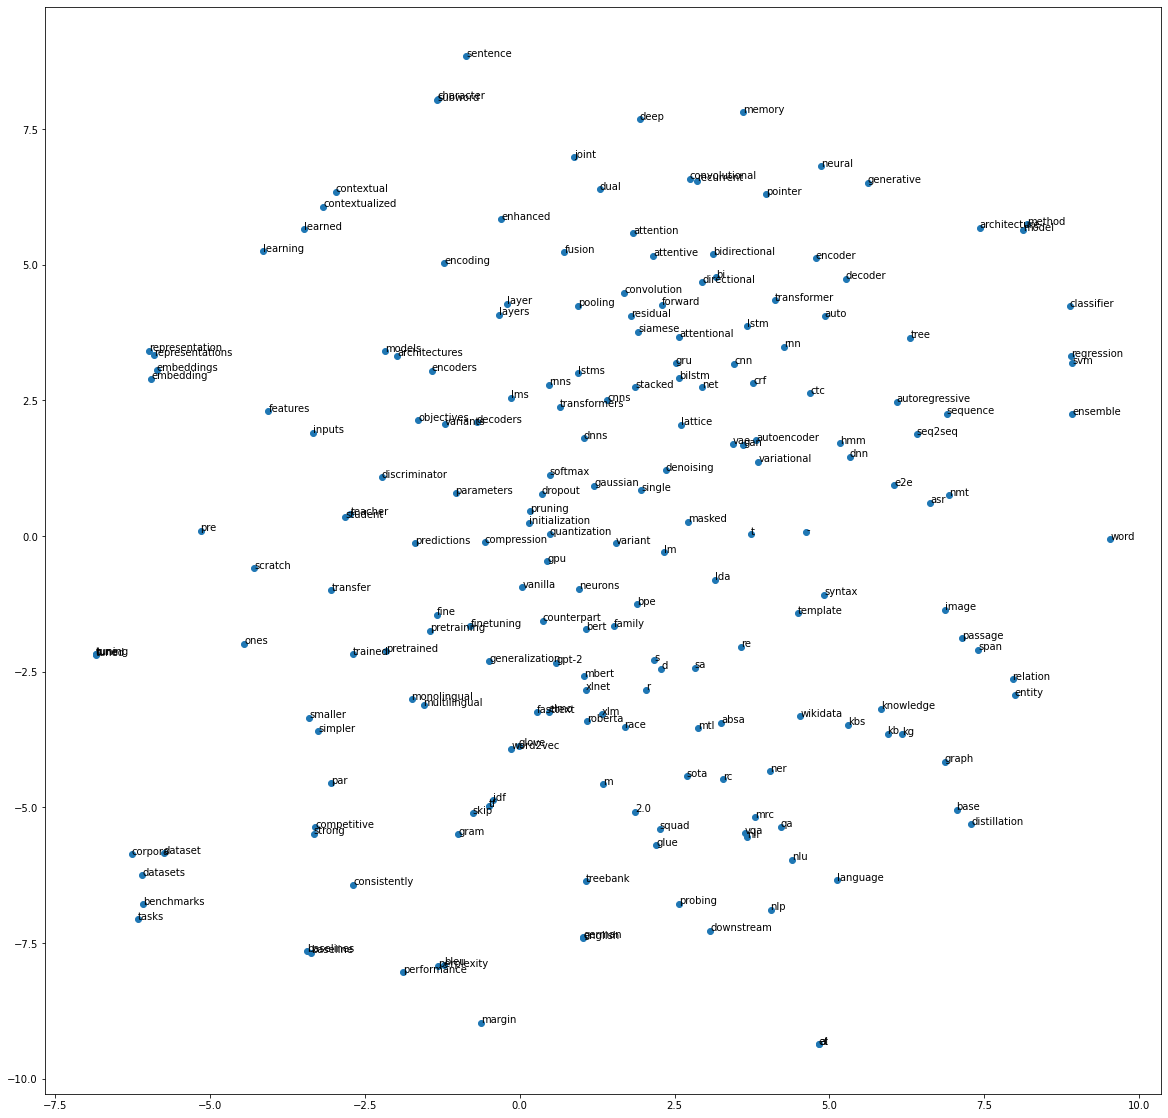

In [ ]:
#| export
plt.figure(figsize=(20,20))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(selected_words):
    plt.annotate(txt, (x[i], y[i]))

## Exploring hyperparameters

What is the quality of the embeddings? Should embeddings capture syntax or semantical relations. Semantic similarity or topical relations?

One way of monitoring the quality is to check nearest neighbours: Are they two nouns, two verbs?

In [ ]:
#| export
import spacy

nlp = spacy.load('en_core_web_sm')

word2pos = {}
for word in model.wv.key_to_index: # model call can be 
    word2pos[word] = nlp(word)[0].pos_

word2pos["translation"]

'NOUN'

In [ ]:
#| export
import numpy as np

def evaluate(model, word2pos):
    same = 0
    for word in model.wv.key_to_index:
        most_similar = model.wv.similar_by_word(word, topn=1)[0][0]
        if word2pos[most_similar] == word2pos[word]:
            same = same + 1
    return same/len(model.wv.key_to_index)

evaluate(model, word2pos)


0.6608583414004517

Now we want to change some of the settings we used above:

- embedding size (dimensions of the trained embeddings): 100, 200, 300
- context window: 2, 5, 10

We will use a Pandas dataframe to keep track of the different scores (but this will take time: We train 9 models!!!):

In [ ]:
#| export
sizes = [100, 200, 300]
windows = [2,5,10]

df = pd.DataFrame(index=windows, columns=sizes)

for size in sizes:
    for window in windows:
        print("Size:", size, "Window:", window)
        model = gensim.models.Word2Vec(documents, min_count=100, window=window, vector_size=size)
        acc = evaluate(model, word2pos)
        df[size][window] = acc
        
df

Size: 100 Window: 2
Size: 100 Window: 5
Size: 100 Window: 10
Size: 200 Window: 2
Size: 200 Window: 5
Size: 200 Window: 10
Size: 300 Window: 2
Size: 300 Window: 5
Size: 300 Window: 10


,100,200,300
2,0.691191,0.686996,0.690545
5,0.664408,0.664408,0.655373
10,0.626008,0.633107,0.636657


Results are close:

1. Smaller contexts seem to yield better results. Which makes sense because we work with the syntax - nearer words often produce more information.
2. Higher dimension word embeddings not always work better than lower dimension. Here we have a relatively small corpus, not enough data for such higher dimensions.

Let's visualize our findings:

<AxesSubplot:>

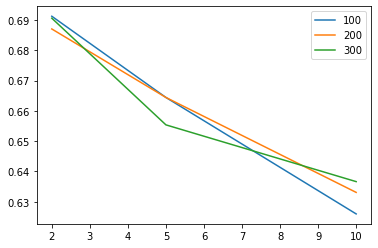

In [ ]:
#| export
df.plot()

## Conclusions

Word embeddings allow us to model the usage and meaning of a word, and discover words that behave in a similar way.

We move from raw strings -> vector space: word embeddings which allows us to work with words that have a similar meaning and discover new patterns.